In [1]:
import numpy as np
import scipy.stats as ss

import jax
import jax.numpy as jnp
import jax.scipy.stats as jss
import jax.scipy.special as jsss

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import pathfinder

def ellipse_confidence(mu, cov, ax, c, n_std=2.):
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)
    ellipse = Ellipse(xy=(*mu,),
                      width=lambda_[0]*n_std*2, height=lambda_[1]*n_std*2,
                      angle=np.degrees(np.arctan2(*v[:,0][::-1])),
                     facecolor=c,edgecolor="b", alpha=0.1)
    return ax.add_artist(ellipse)

### Pathfinder: parallel quasi-newton variational inference 

*(from abstact)* Starting from a random initialization, Pathfinder locates normal approximations to the target
density along a quasi-Newton optimization path, with local covariance estimated using the inverse Hessian
estimates produced by the optimizer. Pathfinder returns draws from the approximation with the lowest
estimated Kullback-Leibler (KL) divergence to the true posterior.

Here we show the full L-BFGS optimization path with 95% central region of pathfinder samples and estimate ELBO wrt target distribution for each step of the algorithm.

#### Bivariate normal:

In [27]:
rng_key = jax.random.PRNGKey(0)

mu = jnp.zeros(2)
cov = jnp.array([[1.0, -0.9], 
                 [-0.9, 1.0]])

x0 = jnp.array([1.75,2.05])
logp_fn = lambda x: jax.scipy.stats.multivariate_normal.logpdf(x, mu, cov)

maxcor, maxiter = 10, 10
elbos, xs, phis = pathfinder.pathfinder(rng_key, logp_fn, x0, maxiter, maxcor, 10000, output='all')
xs = jnp.stack(xs)

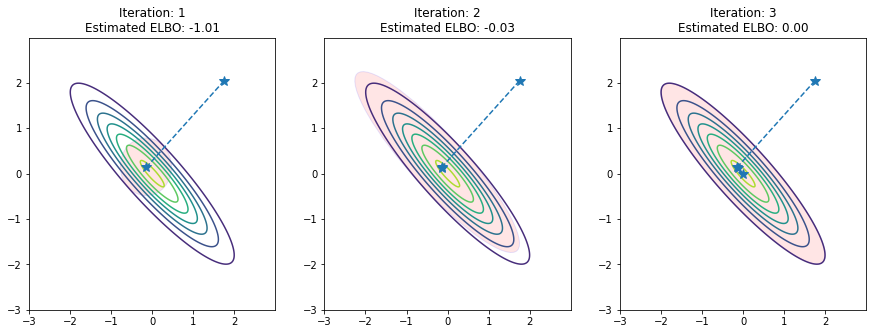

In [28]:
step = 0.01
x, y = jnp.mgrid[-3:3:step, -3:3:step]
pos = jnp.dstack((x, y))
rv = ss.multivariate_normal.pdf(pos, mu, cov)

rows = int(np.ceil((len(xs)-1) / 3))
fig,axs = plt.subplots(rows, 3, figsize=(15, 5*rows))
for i,ax in zip(range(1,len(xs)), axs.flatten()):
    ax.contour(x,y,rv)
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    ax.plot(xs[0:i+1,0], xs[0:i+1,1], marker="*", linestyle="--",markersize=10)
    mu_i, cov_i = phis[i].mean(0), jnp.cov(phis[i],rowvar=False)
    ellipse_confidence(mu_i,cov_i, ax, "r")
    ax.set_title(f"Iteration: {i}\nEstimated ELBO: {elbos[i]:.2f}")
    ax.set_xlim(*xlim), ax.set_ylim(*ylim)

#### Posterior of binomial model:
(chart should resemble *figure 1* of the paper)

In [29]:
n, p = 1000, 2
true_beta_mu = jnp.array([0.6,-0.4])

X = np.random.normal(size=(n,p))
betas = np.random.multivariate_normal(true_beta_mu, np.eye(p), size=n)
Y = np.random.binomial(1,jsss.expit((betas*X).sum(1)))

prior_beta_logp = lambda beta: jss.multivariate_normal.logpdf(beta, mean=jnp.zeros(p), cov=jnp.eye(p))
logp_model = jax.vmap(lambda beta: jss.bernoulli.logpmf(Y,jsss.expit(X@beta)).sum(-1) + prior_beta_logp(beta))
logp_model_ = lambda beta: logp_model(jnp.atleast_2d(beta)) # lbfgs routine needs 1d arrays, vmap 2d's...

maxcor, maxiter = 10, 20
sample = jnp.array([[1.5, -1.5]])

elbos, xs, phis = pathfinder.pathfinder(rng_key, logp_model_, sample[0], maxiter, maxcor, 1000, output='all')
xs = jnp.stack(xs)

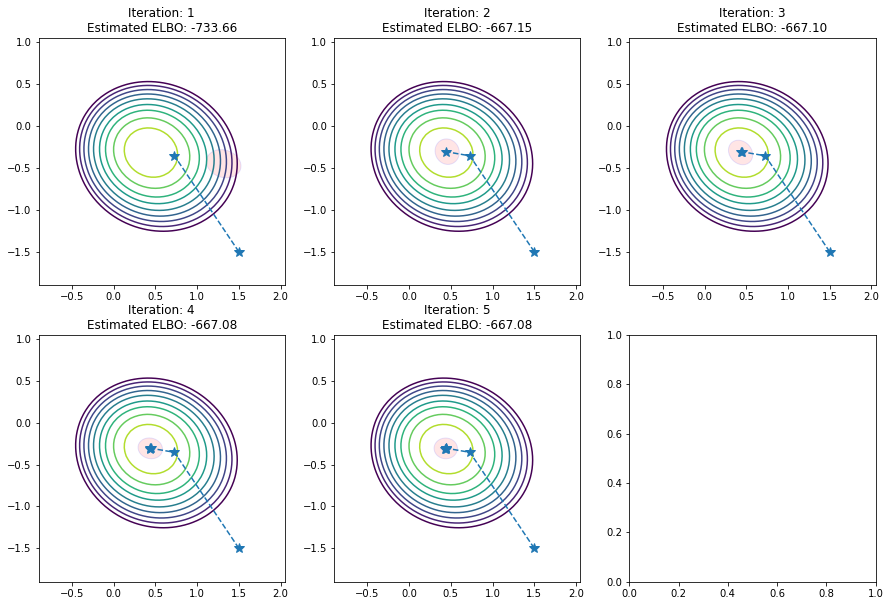

In [26]:
step, size = 0.05, 1.5
x, y = jnp.mgrid[true_beta_mu[0]-size:true_beta_mu[0]+size:step, true_beta_mu[1]-size:true_beta_mu[1]+size:step,]
pos = jnp.dstack((x, y))
rv = logp_model(pos.reshape(-1,p)).reshape(*x.shape)
levels = np.percentile(rv.flatten(),np.linspace(70,100,10))

rows = int(np.ceil((len(xs)-1) / 3))
fig,axs = plt.subplots(rows, 3, figsize=(15, 5*rows))
for i,ax in zip(range(1,len(xs)), axs.flatten()):
    ax.contour(x,y,rv,levels=levels)
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    ax.plot(xs[0:i+1,0], xs[0:i+1,1], marker="*", linestyle="--",markersize=10)
    mu_i, cov_i = phis[i].mean(0), jnp.cov(phis[i],rowvar=False)
    ellipse_confidence(mu_i,cov_i, ax, "r")
    ax.set_title(f"Iteration: {i}\nEstimated ELBO: {elbos[i]:.2f}")
    ax.set_xlim(*xlim), ax.set_ylim(*ylim)

#### Funnel-like posterior distribution
(chart should resemble *figure 2* of the paper)

In [34]:
n, p = 1, 2

logp_tao_prior = lambda tao : jss.norm.logpdf(tao, 0, 1.)
logp_mu_prior = lambda mu: jss.norm.logpdf(mu, 0., 1.)
logp_obs = lambda obs, mu, tao: jss.norm.logpdf(obs, mu, jnp.exp(tao))
obs = jax.random.normal(rng_key) * 2e-2
logp_model = lambda x : logp_obs(obs, jnp.take(x,0,-1), jnp.take(x,1,-1)) \
                        + logp_mu_prior(jnp.take(x,0,-1)) + logp_tao_prior(jnp.take(x,1,-1))

x0 = jnp.array([2.,1.])
elbos, xs, phis = pathfinder.pathfinder(rng_key, logp_model, x0, maxiter, maxcor, 1000, output='all')
xs = jnp.stack(xs)

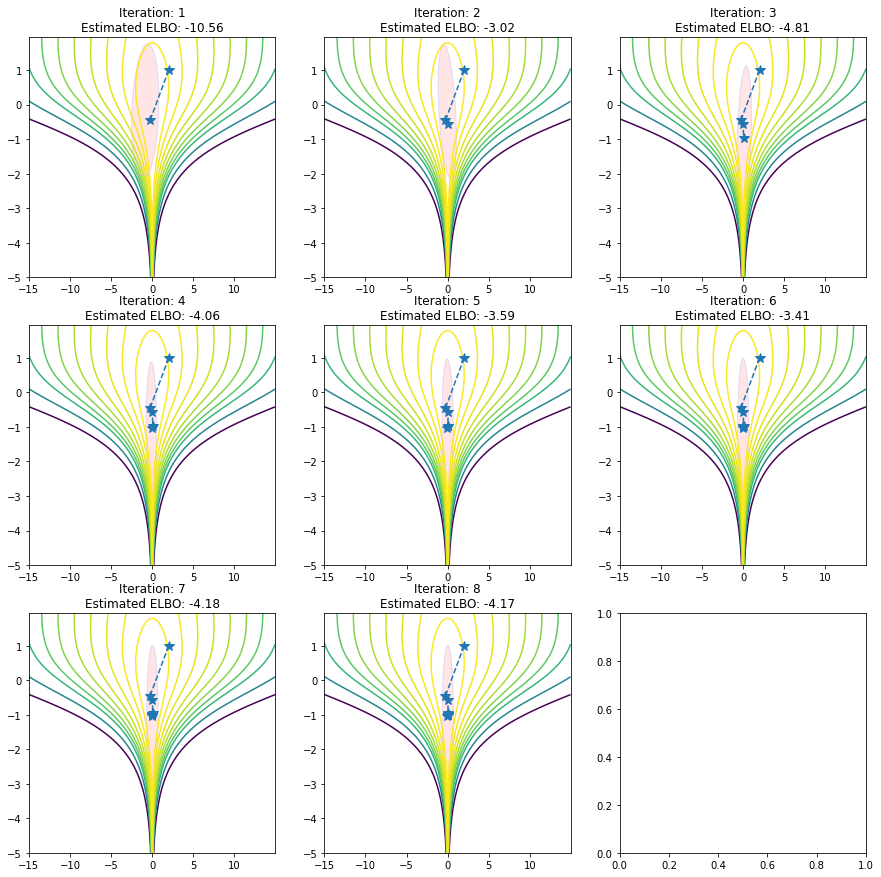

In [35]:
step, size = 0.05, 15
x, y = jnp.mgrid[0.-size:0.+size:step, -5:2:step]
pos = jnp.dstack((x, y))
rv = logp_model(pos.reshape(-1,p)).reshape(*x.shape)

levels = np.percentile(rv.flatten(),np.linspace(50,95,10))

rows = int(np.ceil((len(xs)-1) / 3))
fig,axs = plt.subplots(rows, 3, figsize=(15, 5*rows))
for i,ax in zip(range(1,len(xs)), axs.flatten()):
    ax.contour(x,y,rv,levels=levels)
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    ax.plot(xs[0:i+1,0], xs[0:i+1,1], marker="*", linestyle="--",markersize=10)
    mu_i, cov_i = phis[i].mean(0), jnp.cov(phis[i],rowvar=False)
    ellipse_confidence(mu_i,cov_i, ax, "r")
    ax.set_title(f"Iteration: {i}\nEstimated ELBO: {elbos[i]:.2f}")
    ax.set_xlim(*xlim), ax.set_ylim(*ylim)